In [2]:
use std::cell::{Ref, RefCell};
use std::collections::HashSet;
use std::rc::Rc;

#[derive(Clone, Eq, PartialEq, Debug)]
pub struct Value(Rc<RefCell<Values>>);

pub struct Values {
    data: f64,
    grad: f64,
    op: Option<String>,
    prev: Vec<Value>,
    _backward: Option<fn(value: &Ref<Values>)>,
}

impl Values {
    fn new(data: f64, op: Option<String>, prev: Vec<Value>, _backward: Option<fn(value: &Ref<Values>)>) -> Values {
        Values {
            data,
            grad: 0.0,
            op,
            prev,
            _backward,
        }
    }
}

impl Value {
    pub fn from<T: Into<Value>>(t: T) -> Value {
        t.into()
    }

    fn new(value: Values) -> Value {
        Value(Rc::new(RefCell::new(value)))
    }

    pub fn data(&self) -> f64 {
        self.borrow().data
    }

    pub fn grad(&self) -> f64 {
        self.borrow().grad
    }

    pub fn zero_grad(&self) {
        self.borrow_mut().grad = 0.0;
    }

    pub fn adjust(&self, val: f64) {
        let mut value = self.borrow_mut();
        value.data += val * value.grad;
    }

    pub fn add(a: &Value, b: &Value) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            out.prev[0].borrow_mut().grad += out.grad;
            out.prev[1].borrow_mut().grad += out.grad;
        };

        Value::new(Values::new(
            a.borrow().data + b.borrow().data,
            Some("+".to_string()),
            vec![a.clone(), b.clone()],
            Some(_backward),
        ))
    }

    pub fn mul(a: &Value, b: &Value) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            out.prev[0].borrow_mut().grad += out.prev[1].borrow().data * out.grad;
            out.prev[1].borrow_mut().grad += out.prev[0].borrow().data * out.grad;
        };

        Value::new(Values::new(
            a.borrow().data * b.borrow().data,
            Some("*".to_string()),
            vec![a.clone(), b.clone()],
            Some(_backward),
        ))
    }

    pub fn pow(&self, other: &Value) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            let mut base = out.prev[0].borrow_mut(); // I want to remove this
            base.grad += out.prev[1].borrow().data * (base.data.powf(out.prev[1].borrow().data - 1.0)) * out.grad;
        };

        Value::new(Values::new(
            self.borrow().data.powf(other.borrow().data),
            Some("^".to_string()),
            vec![self.clone(), other.clone()],
            Some(_backward),
        ))
    }

    // Negative power ie x^-1, this will allow us to divide
    pub fn powneg(&self) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            let mut base = out.prev[0].borrow_mut(); // and remove this
            base.grad += -(1.0 / base.data.powf(2.0)) * out.grad;
        };

        Value::new(Values::new(
            1.0 / self.borrow().data,
            Some("^".to_string()),
            vec![self.clone()],
            Some(_backward),
        ))
    }
    pub fn tanh(&self) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            let out1 = out.prev[0].borrow().data.tanh();
            let mut outue = out.prev[0].borrow_mut();
            outue.grad += (1.0 - out1.powf(2.0)) * out.grad;
        };

        Value::new(Values::new(
            self.borrow().data.tanh(),
            Some("tanh".to_string()),
            vec![self.clone()],
            Some(_backward),
        ))
    }

    pub fn exp(self) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            out.prev[0].borrow_mut().grad += out.data * out.grad;
        };
        Value::new(Values::new(
            self.borrow().data.exp(),
            Some("exp".to_string()),
            vec![self.clone()],
            Some(_backward),
        ))
    }

    pub fn relu(self) -> Value {
        let _backward: fn(value: &Ref<Values>) = |out| {
            out.prev[0].borrow_mut().grad += if out.data > 0.0 {out.grad} else { 0.0 };
        };

        Value::new(Values::new(
            self.borrow().data.max(0.0),
            Some("ReLU".to_string()),
            vec![self.clone()],
            Some(_backward),
        ))
    }

    pub fn sum<I: Iterator<Item = Self>>(mut iter: I) -> Self {
        // iter.fold(Value::from(0.0), |sum, val| sum + val) <- For some reason I couldn't get this
        // to work
        let mut sum = Value::from(0.0);
        loop {
            let val = iter.next();
            if val.is_none() {
                break;
            }
            sum = sum + val.unwrap();
        }
        sum
    }

    pub fn backward(&self) {
        let mut topo: Vec<Value> = vec![];
        let mut visited: HashSet<Value> = HashSet::new();
        self._build_topo(&mut topo, &mut visited);
        topo.reverse();

        self.borrow_mut().grad = 1.0;
        for v in topo {
            if let Some(backprop) = v.borrow()._backward {
                backprop(&v.borrow());
            }
        }
    }

    fn _build_topo(&self, topo: &mut Vec<Value>, visited: &mut HashSet<Value>) {
        if visited.insert(self.clone()) {
            self.borrow().prev.iter().for_each(|child| {
                child._build_topo(topo, visited);
            });
            topo.push(self.clone());
        }
    }

}

impl std::fmt::Debug for Values {
    fn fmt(&self, f: &mut std::fmt::Formatter<'_>) -> std::fmt::Result {
        write!(f, "Value(data={}, grad={})", self.data, self.grad)
    }
}

/*
----------------------------------------------------------------------------------
Rust requires this boilerplate for stuff like hashset, derefrenceing into etc.
----------------------------------------------------------------------------------
*/
impl std::hash::Hash for Value {
    fn hash<H: std::hash::Hasher>(&self, state: &mut H) {
        self.0.borrow().hash(state);
    }
}

impl std::ops::Deref for Value {
    type Target = Rc<RefCell<Values>>;

    fn deref(&self) -> &Self::Target {
        &self.0
    }
}

impl<T: Into<f64>> From<T> for Value {
    fn from(t: T) -> Value {
        Value::new(Values::new(t.into(), None, Vec::new(), None))
    }
}

impl PartialEq for Values {
    fn eq(&self, other: &Self) -> bool {
        self.data == other.data && self.grad == other.grad && self.op == other.op && self.prev == other.prev
    }
}

impl Eq for Values {}

impl std::hash::Hash for Values {
    fn hash<H: std::hash::Hasher>(&self, state: &mut H) {
        self.data.to_bits().hash(state);
        self.grad.to_bits().hash(state);
        self.op.hash(state);
        self.prev.hash(state);
    }
}

/*
------------------------------------------------------------------------------------------------
This allows us to use Value + Value instead of Value.add(Value), just so it works like micrograd
------------------------------------------------------------------------------------------------
*/
impl std::ops::Add<Value> for Value {
    type Output = Value;

    fn add(self, other: Value) -> Self::Output {
        Value::add(&self, &other)
    }
}

impl<'a, 'b> std::ops::Add<&'b Value> for &'a Value {
    type Output = Value;

    fn add(self, other: &'b Value) -> Self::Output {
        Value::add(self, other)
    }
}

impl std::ops::Sub<Value> for Value {
    type Output = Value;

    fn sub(self, other: Value) -> Self::Output {
        Value::add(&self, &(-other))
    }
}

impl<'a, 'b> std::ops::Sub<&'b Value> for &'a Value {
    type Output = Value;

    fn sub(self, other: &'b Value) -> Self::Output {
        Value::add(self, &(-other))
    }
}

impl std::ops::Mul<Value> for Value {
    type Output = Value;

    fn mul(self, other: Value) -> Self::Output {
        Value::mul(&self, &other)
    }
}

impl<'a, 'b> std::ops::Mul<&'b Value> for &'a Value {
    type Output = Value;

    fn mul(self, other: &'b Value) -> Self::Output {
        Value::mul(self, other)
    }
}

impl std::ops::Div<Value> for Value {
    type Output = Value;

    fn div(self, other: Value) -> Self::Output {
        Value::mul(&self, &other.powneg())
    }
}

impl<'a, 'b> std::ops::Div<&'b Value> for &'a Value {
    type Output = Value;

    fn div(self, other: &'b Value) -> Self::Output {
        Value::mul(self, &other.powneg())
    }
}

impl std::ops::Neg for Value {
    type Output = Value;

    fn neg(self) -> Self::Output {
        Value::mul(&self, &Value::from(-1))
    }
}

impl<'a> std::ops::Neg for &'a Value {
    type Output = Value;

    fn neg(self) -> Self::Output {
        Value::mul(self, &Value::from(-1))
    }
}

impl std::iter::Sum for Value {
    fn sum<I: Iterator<Item = Self>>(iter: I) -> Self {
        Value::sum(iter)
    }
}


In [3]:
:dep rand = "*"
use rand::Rng;

pub struct Neuron {
    w: Vec<Value>,
    b: Value,
    nonlin: bool,
}

impl Neuron {
    pub fn new(nin: usize, nonlin: bool) -> Neuron {
        Neuron {
            w: (0..nin).map(|_| Value::from(rand::thread_rng().gen_range(-1.0..=1.0))).collect(),
            b: Value::from(rand::thread_rng().gen_range(-1.0..=1.0)),
            nonlin,
        }
    }

    pub fn forward(&self, x: &Vec<Value>) -> Value {
        let out = (std::iter::zip(&self.w, x)
            .map(|(wi, xi)| wi * xi)
            .collect::<Vec<_>>()
            .into_iter()
            .reduce(|a, b| a + b)
            .unwrap())
            + self.b.clone();
        if self.nonlin {
            out.relu()
        } else {
            out
        }
    }

    pub fn parameters(&self) -> Vec<Value> {
        [self.w.clone(), vec![self.b.clone()]].concat()
    }
}

impl std::fmt::Debug for Neuron {
    fn fmt(&self, f: &mut std::fmt::Formatter<'_>) -> std::fmt::Result {
        write!(f, "{}Neuron({})", if self.nonlin { "ReLU" } else { "Linear" }, self.w.len())
    }
}

pub struct Layer {
    neurons: Vec<Neuron>,
}

impl Layer {
    pub fn new(nin: usize, nout: usize, nonlin: bool) -> Layer {
        Layer {
            neurons: (0..nout).map(|_| Neuron::new(nin, nonlin)).collect(),
        }
    }

    pub fn forward(&self, x: &Vec<Value>) -> Vec<Value> {
        self.neurons.iter().map(|i| i.forward(x)).collect::<Vec<_>>()
    }

    pub fn parameters(&self) -> Vec<Value> {
        self.neurons.iter().flat_map(|neuron| neuron.parameters()).collect()
    }
}

impl std::fmt::Debug for Layer {
    fn fmt(&self, f: &mut std::fmt::Formatter<'_>) -> std::fmt::Result {
        write!(
            f,
            "Layer of [{:?}]",
            self.neurons.iter().map(|n| format!("{:?}", n)).collect::<Vec<_>>().join(", ")
        )
    }
}

pub struct MLP {
    layers: Vec<Layer>,
}

impl MLP {
    pub fn new(nin: usize, nouts: Vec<usize>) -> MLP {
        MLP {
            layers: (0..nouts.len())
                .map(|i| {
                    Layer::new(
                        vec![nin].into_iter().chain(nouts.clone().into_iter()).collect::<Vec<_>>()[i],
                        nouts[i],
                        i != nouts.len() - 1,
                    )
                })
                .collect(),
        }
    }

    pub fn forward(&self, x: Vec<Value>) -> Vec<Value> {
        self.layers.iter().fold(x, |x, layer| layer.forward(&x))
    }

    pub fn parameters(&self) -> Vec<Value> {
        self.layers.iter().flat_map(|layer| layer.parameters()).collect()
    }
}

impl std::fmt::Debug for MLP {
    fn fmt(&self, f: &mut std::fmt::Formatter<'_>) -> std::fmt::Result {
        write!(
            f,
            "MLP of [{}]",
            self.layers.iter().map(|l| format!("{:?}", l)).collect::<Vec<_>>().join(", ")
        )
    }
}


In [4]:
// This is literally here to be able to visualize our results using a Jupyter notebook
// So we are just saving it

:dep petgraph = "*"
:dep petgraph-evcxr = "*"
use petgraph::graph::Graph;
use std::collections::HashSet;

use petgraph_evcxr::draw_graph;

fn build(v: Value, nodes: &mut HashSet<Value>, edges: &mut HashSet<(Value, Value)>) {
    if !nodes.contains(&v) {
        nodes.insert(v.clone());
        v.borrow().prev.iter().for_each(|child| {
            edges.insert((child.clone(), v.clone()));
            build(child.clone(), nodes, edges);
        });
    }
}

fn trace(root: Value) -> (HashSet<Value>, HashSet<(Value, Value)>) {
    let mut nodes = HashSet::new();
    let mut edges = HashSet::new();

    build(root, &mut nodes, &mut edges);
    (nodes, edges)
}

pub fn draw_dot(root: Value) {
    let (nodes, edges) = trace(root);
    let mut g = Graph::<String, String>::new();
    let node_ids = nodes
        .iter()
        .map(|n| {
            (
                n.clone(),
                g.add_node(format!("data {:.4} \ngrad {:.4} ", n.borrow().data, n.borrow().grad)),
            )
        })
        .collect::<Vec<_>>();

    edges.iter().for_each(|(n1, n2)| {
        let node_id1 = node_ids.iter().find(|(n, _)| n == n1).unwrap().1;
        let node_id2 = node_ids.iter().find(|(n, _)| n == n2).unwrap().1;
        g.add_edge(node_id1, node_id2, n2.borrow().op.clone().expect("REASON"));
    });
    draw_graph(&g);
}


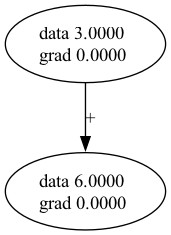

In [5]:
/*
------------
Single node
------------
*/

let a = Value::from(3.0);
let b = &a + &a;
draw_dot(b)

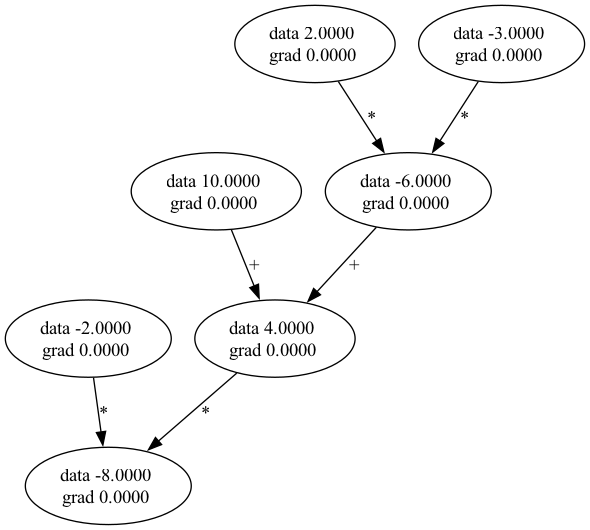

In [6]:
/*
-------------------------------
Example of forward propagation

Works with and without borrowing
"look mah no hands"
--------------------------------
*/
let a = Value::from(2.0);
let b = Value::from(-3.0);
let c = Value::from(10.0);
let e = a*b;
let d = e + c;
let f = Value::from(-2.0,);
let L = d * f;
draw_dot(L);

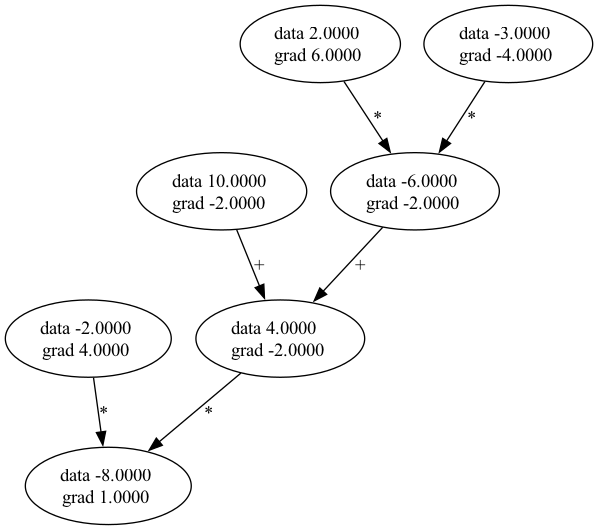

In [7]:
/*
-------------------------------
Example of back propagation

same as last, we just need to call
L.backward()
--------------------------------
*/
let a = Value::from(2.0);
let b = Value::from(-3.0);
let c = Value::from(10.0);
let e = a*b;
let d = e + c;
let f = Value::from(-2.0,);
let L = d * f;
L.backward();
draw_dot(L);

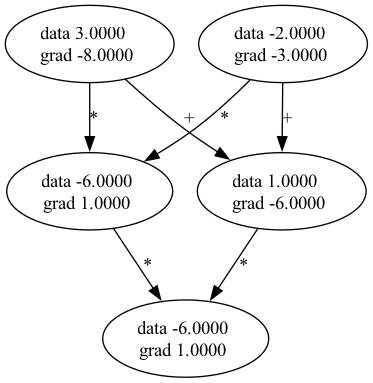

In [8]:
/*
-------------------------------
The order doesn't matter
--------------------------------
*/
let a = Value::from(-2.0);
let b = Value::from(3.0);
let d = &a * &b; 
let e = &a + &b; 
let f = d * e; 
f.backward();
draw_dot(f)

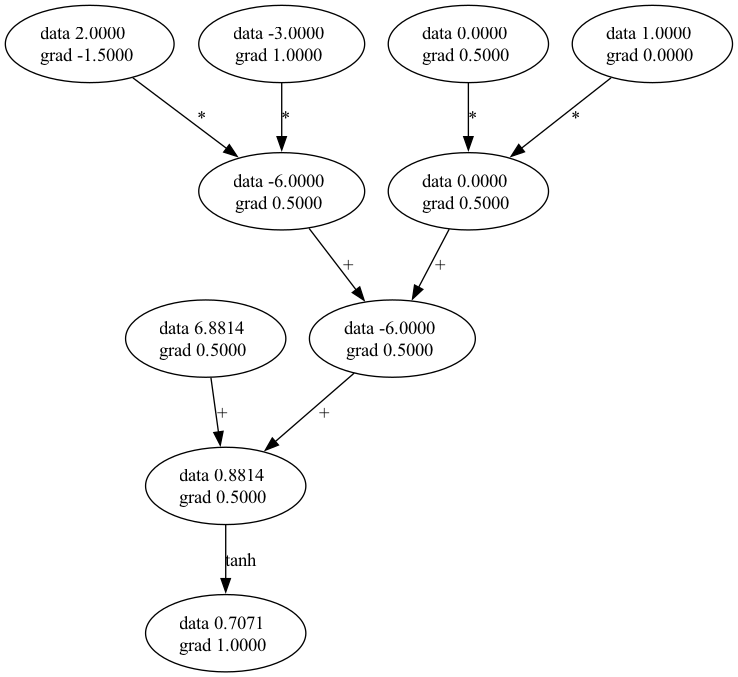

In [9]:
/*
-------------------------------
We even have more complicated 
functions like tanh
--------------------------------
*/
// inputs x1,x2
let x1 = Value::from(2.0);
let x2 = Value::from(0.0);
// weights w1,w2
let w1 = Value::from(-3.0);
let w2 = Value::from(1.0);
// bias of the neuron
let b = Value::from(6.8813735870195432);
// x1*w1 + x2*w2 + b
let x1w1 = x1*w1; 
let x2w2 = x2*w2; 
let x1w1x2w2 = x1w1 + x2w2; 
let n = x1w1x2w2 + b; 
let o = n.tanh();
o.backward();
draw_dot(o)

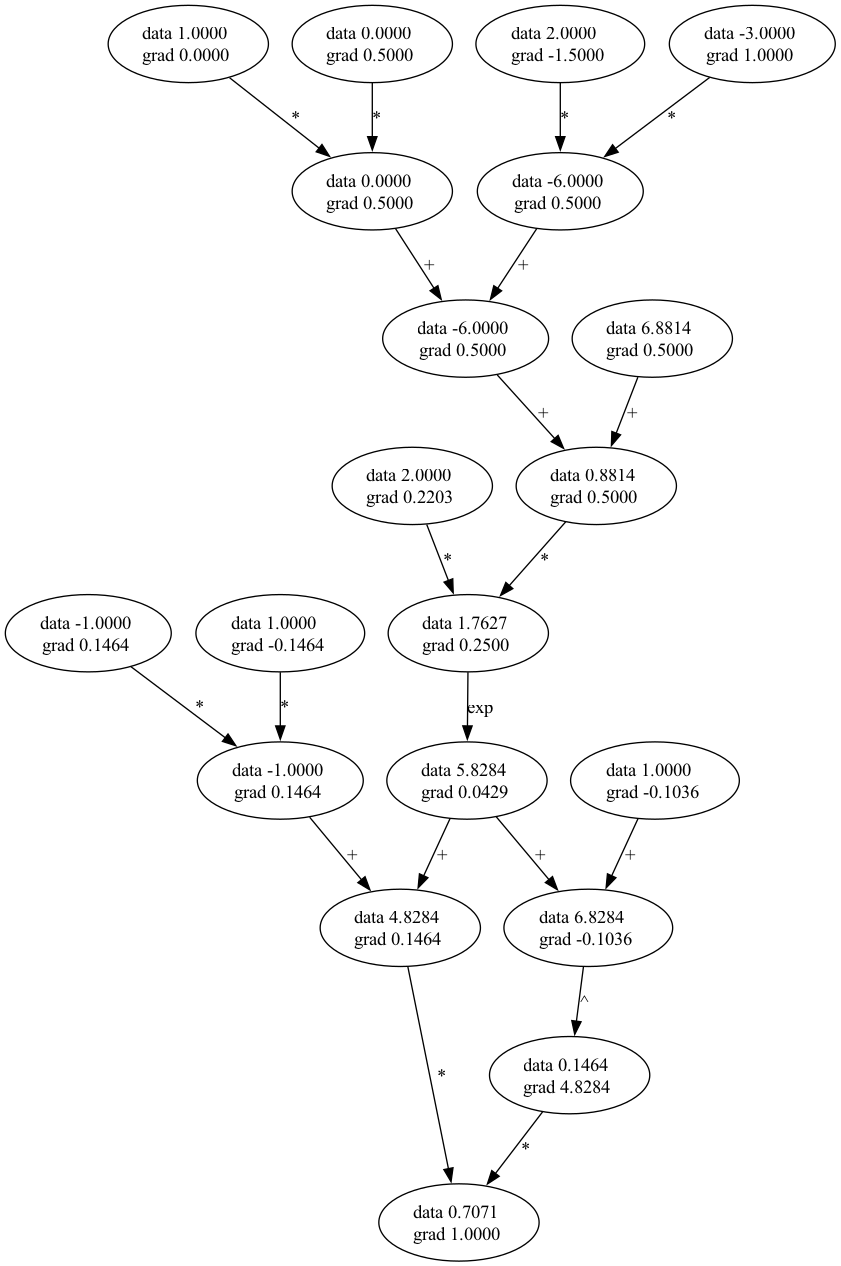

In [10]:
/*
-------------------------------
We can also take out tanh and build
it using (e^x - 1) / (e^x + 1)

we still get the same result
--------------------------------
*/
// inputs x1,x2
let x1 = Value::from(2.0);
let x2 = Value::from(0.0);
// weights w1,w2
let w1 = Value::from(-3.0);
let w2 = Value::from(1.0);
// bias of the neuron
let b = Value::from(6.8813735870195432);
// x1*w1 + x2*w2 + b
let x1w1 = x1*w1; 
let x2w2 = x2*w2; 
let x1w1x2w2 = x1w1 + x2w2; 
let n = x1w1x2w2 + b; 
// ----------
let e = (n * Value::from(2.0)).exp();
let o = (&e -  &Value::from(1.0)) / (e +  Value::from(1.0));
// ----------
o.backward();
draw_dot(o)

In [11]:
/*
-------------------------------
Now for some actual Machine Learning
--------------------------------
*/

let n = MLP::new(3, vec![4, 4, 1]);

let xs = vec![
    vec![2.0, 3.0, -1.0],
    vec![3.0, -1.0, 0.5],
    vec![0.5, 1.0, 1.0],
    vec![1.0, 1.0, -1.0],
];

let ys = vec![1.0, -1.0, -1.0, 1.0]; // desired targets


let range = 20000;
let adjust = -0.001;
for k in 0..range {
    
    // Forward pass
    let ypred: Vec<Value> = xs
        .iter()
        .map(|x| n.forward(x.iter().map(|x| Value::from(*x)).collect())[0].clone())
        .collect();
    let loss: Value = ypred.clone()
        .into_iter()
        .zip(ys.iter().map(|y| Value::from(*y)))
        .map(|(yout, ygt)| (yout - ygt).pow(&2.0.into()))
        .sum();

    // Backward pass
    for p in n.parameters() {
        p.zero_grad();
    }
    loss.backward();

    // Update
    for p in n.parameters() {
        p.adjust(adjust);
    }
    //println!("{k}: Loss: {:.3}", loss.data()); // If we want to print loss
    if k == range-1 {
        println!("\nACTUAL");
        println!("   [{:?}]", ypred.iter().map(|x| format!("{:.3}", x.data())).collect::<Vec<_>>().join(", "));
        println!("DESIRED");
        println!("   [{:?}]", ys.iter().map(|x| format!("{:.3}", x)).collect::<Vec<_>>().join(", "));
    }
}


ACTUAL
   ["1.000, -1.000, -1.000, 1.000"]
DESIRED
   ["1.000, -1.000, -1.000, 1.000"]


()

In [25]:
:dep csv
/*
-------------------------------
Not only that we can also do
graident decent
--------------------------------
*/

let x: Vec<[f64; 2]> = csv::ReaderBuilder::new()
    .from_path("make_moons.csv")
    .unwrap()
    .records()
    .map(|r| {
        let record = r.unwrap();
        [
            record.get(0).unwrap().parse::<f64>().unwrap(),
            record.get(1).unwrap().parse::<f64>().unwrap(),
        ]
    })
    .collect();
let y: Vec<f64> = csv::ReaderBuilder::new()
    .from_path("make_moons.csv")
    .unwrap()
    .records()
    .map(|r| r.unwrap().get(2).unwrap().parse::<f64>().unwrap())
    .collect();

// Initalizing a model
let model = MLP::new(2, vec![10, 10, 1]); // 2-layer neural network
println!("{:?}", model);
println!("number of parameters: {:?}", model.parameters().len());

// loss function
fn loss(xs: Vec<[f64;2]>, ys: Vec<f64>, model: &MLP) -> (Value, f64) {
    let inputs: Vec<Vec<Value>> = xs
        .iter()
        .map(|xrow| vec![Value::from(xrow[0]), Value::from(xrow[1])])
        .collect();

    // forward the model to get scores
    let scores: Vec<Value> = inputs
        .iter()
        .map(|xrow| model.forward(xrow.clone())[0].clone())
        .collect();

    // svm "max-margin" loss
    let losses: Vec<Value> = ys
        .iter()
        .zip(&scores)
        .map(|(yi, scorei)| (Value::from(1.0) + &Value::from(-yi) * scorei).relu())
        .collect();
    let n: f64 = (&losses).len() as f64;
    let data_loss: Value = losses.into_iter().sum::<Value>() / Value::from(n);

    // L2 regularization
    let alpha: f64 = 0.0001;
    let reg_loss: Value = Value::from(alpha)
        * model
            .parameters()
            .iter()
            .map(|p| p * p)
            .into_iter()
            .sum::<Value>();
    let total_loss = data_loss + reg_loss;

    // also get accuracy
    let accuracies: Vec<bool> = ys
        .iter()
        .zip(scores.iter())
        .map(|(yi, scorei)| (*yi > 0.0) == (scorei.borrow().data > 0.0))
        .collect();
    let accuracy = accuracies.iter().filter(|&a| *a).count() as f64 / n;


    (total_loss, accuracy)

}

// optimization
for k in 0..100 {
        // forward
        let (total_loss, acc) = loss(x.clone(), y.clone(), &model);

        // backward
        model.parameters().iter().for_each(|p|p.zero_grad());
    
        total_loss.backward();

        // update (sgd)
        let learning_rate = 1.0 - 0.9 * (k as f64) / 100.0;
        for p in &model.parameters() {
            let delta = learning_rate * p.borrow().grad;
            p.borrow_mut().data -= delta;
        }

        println!(
            "step {k} loss {:.3}, accuracy {:.2}%",
            total_loss.borrow().data,
            acc * 100.0
        );

    }

MLP of [Layer of ["ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)"], Layer of ["ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10), ReLUNeuron(10)"], Layer of ["LinearNeuron(10)"]]
number of parameters: 151


thread '<unnamed>' panicked at src/lib.rs:208:25:
already borrowed: BorrowMutError
stack backtrace:
   0: _rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::cell::panic_already_borrowed
   3: <unknown>
   4: <unknown>
   5: <unknown>
   6: <unknown>
   7: evcxr::runtime::Runtime::run_loop
   8: evcxr::runtime::runtime_hook
   9: evcxr_jupyter::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


In [21]:
:dep csv
:dep poloto
:dep poloto-evcxr
use poloto_evcxr::prelude::*;

// Needed to import the csv
let x: Vec<[f64; 2]> = csv::ReaderBuilder::new()
    .from_path("make_moons.csv")
    .unwrap()
    .records()
    .map(|r| {
        let record = r.unwrap();
        [
            record.get(0).unwrap().parse::<f64>().unwrap(),
            record.get(1).unwrap().parse::<f64>().unwrap(),
        ]
    })
    .collect();
let y: Vec<f64> = csv::ReaderBuilder::new()
    .from_path("make_moons.csv")
    .unwrap()
    .records()
    .map(|r| r.unwrap().get(2).unwrap().parse::<f64>().unwrap())
    .collect();


let (x1, x2): (Vec<[f64; 2]>, Vec<[f64; 2]>) = x.clone()
    .iter()
    .zip(y.clone().iter())
    .fold((Vec::new(), Vec::new()), |mut acc, (x, y)| {
        if *y == -1.0 {
            acc.0.push(x.clone());
        } else if *y == 1.0 {
            acc.1.push(x.clone());
        }
        acc
    });


let datas = poloto::plots!(poloto::build::plot("").scatter(&x1), poloto::build::plot("").scatter(&x2));

poloto::frame_build()
    .data(poloto::plots!(poloto::build::origin(), datas))
    .build_and_label(("", "", ""))
    .append_to(poloto::header().dark_theme())
    .render_evcxr_img();
